In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

In [90]:
structures = ['adipocyte', 'bone', 'sinusoid', 'art'
                ,'stroma', 'macrophage', 
                ]
cls = 'celltype'
combined_df = None
for structure in structures:
    sample_list = np.loadtxt('output_f/sample_list_' + structure + '.txt', dtype=str, delimiter="\n")
    celltype_list = np.loadtxt('output_f/celltype_list_' + structure + '.txt', dtype=str, delimiter="\n")
    coefficients_list_1 = np.loadtxt('output_f/coefficients_list_1_' + structure + '.txt', dtype=float)
    coefficients_list_2 = np.loadtxt('output_f/coefficients_list_2_' + structure + '.txt', dtype=float)
    pop_list = np.loadtxt('output_f/pop_list_' + structure + '.txt', dtype=float)
    distance_mean_list = np.loadtxt('output_f/distance_mean_list_' + structure + '.txt', dtype=float)
    distance_sd_list = np.loadtxt('output_f/distance_sd_list_' + structure + '.txt', dtype=float)
    pvalue_list = np.loadtxt('output_f/pvalue_list_' + structure + '.txt', dtype=float)
    iqr_list = np.loadtxt('output_f/iqr_list_' + structure + '.txt', dtype=float)
    # replace 'nan' with np.nan
    # distance_sd_list = [np.nan if x=='NA' else float(x) for x in distance_sd_list]
    # # replace nan with mean
    # distance_sd_list = [np.mean(distance_sd_list) if np.isnan(x) else x for x in distance_sd_list]
    df = pd.DataFrame({'sample':sample_list, 'celltype':celltype_list, 'coefficients_1':coefficients_list_1, 'coefficients_2':coefficients_list_2, 'populations':pop_list, 
                       'distance_median':distance_mean_list, 'distance_sd':distance_sd_list, 'pvalue':pvalue_list, 
                       'distance_iqr':iqr_list})
    
    df['type'] = 'Healthy'
    df['distance_median'] = df['distance_median']*0.5
    df['distance_iqr'] = df['distance_iqr']*0.5
    df['distance_sd'] = df['distance_sd']*0.5
    df['structure'] = structure
    df['structure'] = df['structure'].replace('art', 'arteriole')
    df['-coefficients_2'] = -df['coefficients_2']
    df['rank'] = df.groupby(by=['sample','structure'])['-coefficients_2'].rank(ascending=False)
    # normalize the rank within each sample
    df['normalized_rank'] = df.groupby(by=['sample','structure'])['rank'].apply(lambda x: (x.rank()-1)/(len(x)-1))

    if combined_df is None:
        combined_df = df
    else:
        combined_df = pd.concat([combined_df, df])

cnt = combined_df.groupby(by=['structure','celltype']).agg({'sample':pd.Series.nunique})
# if sample size is less than 6, remove that item from combined_df
if len(cnt[cnt['sample']<6]>0):
    cnt = cnt.reset_index()
    cnt[cnt['sample']<6].to_csv('result/combined_v3_health_' + cls + '_remove.csv', index=False)
    cnt = cnt[cnt['sample']>=6]
    cnt = cnt[['structure','celltype']]
    combined_df = pd.merge(combined_df, cnt, on=['structure','celltype'], how='inner')

combined_df.to_csv('result/combined_v3_health_' + cls + '.csv', index=False)
combined_df

,sample,celltype,coefficients_1,coefficients_2,populations,distance_median,distance_sd,pvalue,distance_iqr,type,structure,-coefficients_2,rank,normalized_rank
0,H10,Early Myeloid Progenitor,-8.965531,0.000849,944.0,10.519304,3.947396,0.00,13.981482,Healthy,adipocyte,-0.000849,8.0,0.304348
1,H14,Early Myeloid Progenitor,-9.973519,-0.003652,353.0,9.740199,4.341430,0.00,15.701044,Healthy,adipocyte,0.003652,10.0,0.409091
2,H26,Early Myeloid Progenitor,-9.338873,-0.012543,625.0,7.652877,2.827767,0.00,9.790089,Healthy,adipocyte,0.012543,3.0,0.080000
3,H27,Early Myeloid Progenitor,-9.162814,-0.012531,915.0,8.888580,3.250715,0.00,11.164808,Healthy,adipocyte,0.012531,4.0,0.125000
4,H32,Early Myeloid Progenitor,-8.897807,-0.005282,577.0,12.197765,4.946548,0.00,17.669465,Healthy,adipocyte,0.005282,7.0,0.230769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1930,H36,GMP,-12.750858,-0.022508,48.0,18.678804,5.532973,0.34,17.553285,Healthy,macrophage,0.022508,11.0,0.344828
1931,H37,GMP,-12.734731,-0.028467,71.0,16.486038,3.445251,0.08,12.203607,Healthy,macrophage,0.028467,5.0,0.133333
1932,H38,GMP,-12.773871,-0.027859,44.0,18.735825,4.013667,0.26,14.529751,Healthy,macrophage,0.027859,2.0,0.037037
1933,H39,GMP,-12.812732,-0.031163,26.0,20.055217,3.925479,0.52,13.158250,Healthy,macrophage,0.031163,1.0,0.000000


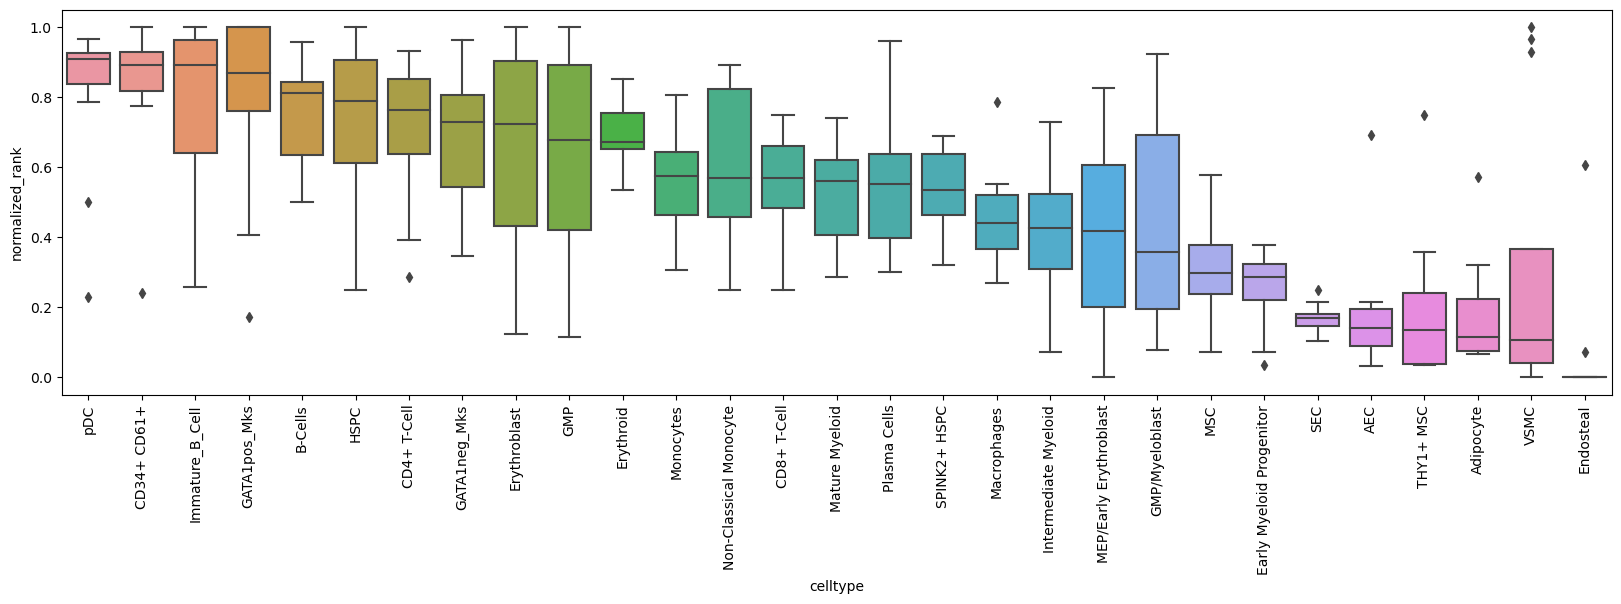

In [91]:
plt.figure(figsize=(20,5))
my_order = combined_df[combined_df['structure']=='bone'].groupby(by=['celltype'])['normalized_rank'].median().sort_values(ascending=False).index
sns.boxplot(x='celltype', y='normalized_rank', data=combined_df[combined_df['structure']=='bone'], order=my_order)
plt.xticks(rotation=90)
plt.show()

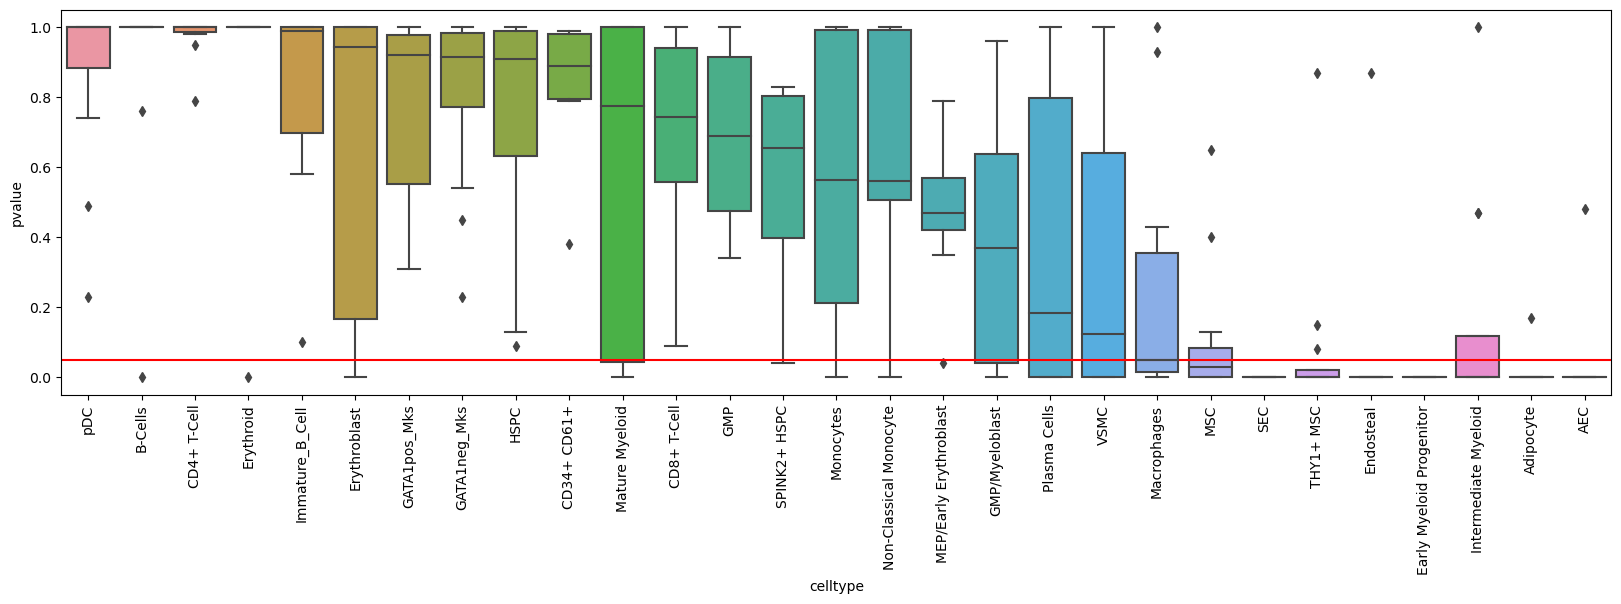

In [92]:
plt.figure(figsize=(20,5))
my_order = combined_df[combined_df['structure']=='bone'].groupby(by=['celltype'])['pvalue'].median().sort_values(ascending=False).index
sns.boxplot(x='celltype', y='pvalue', data=combined_df[combined_df['structure']=='bone'], order=my_order)
plt.axhline(y=0.05, color='r', linestyle='-')
plt.xticks(rotation=90)
plt.show()

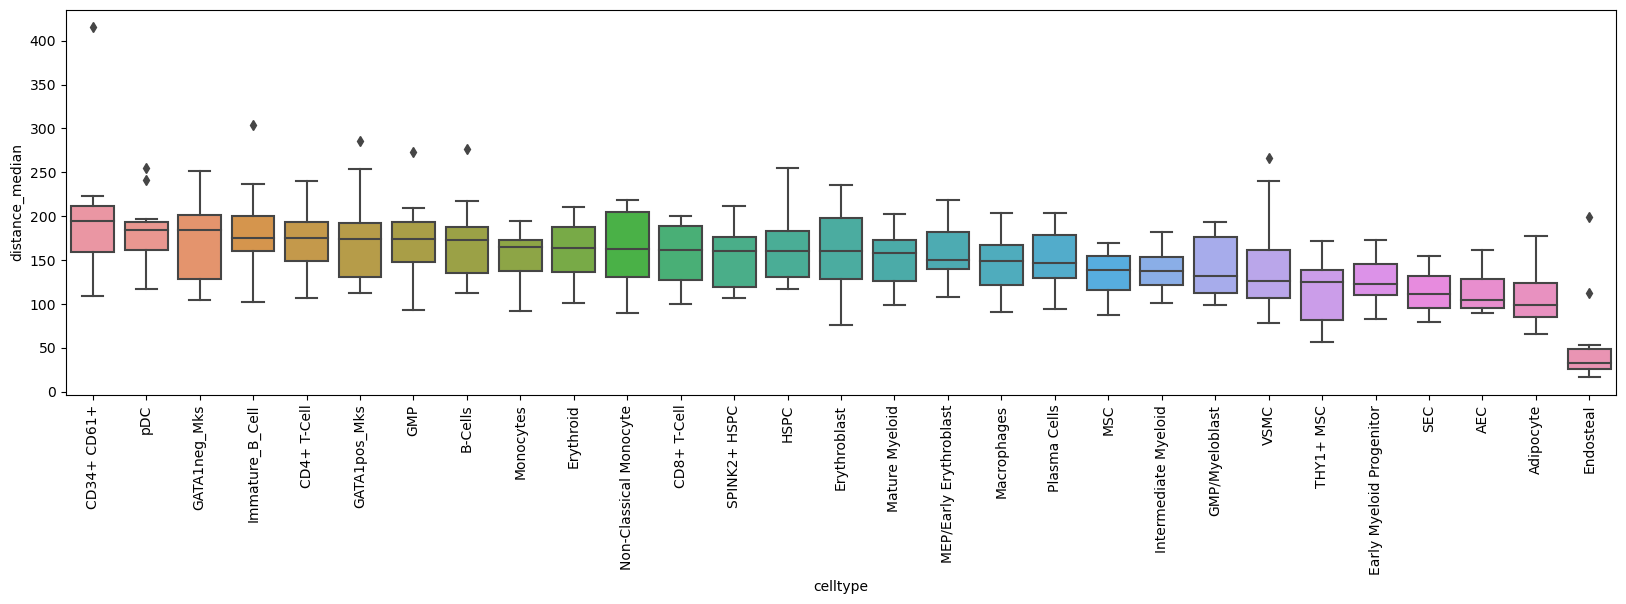

In [93]:
plt.figure(figsize=(20,5))
my_order = combined_df[combined_df['structure']=='bone'].groupby(by=['celltype'])['distance_median'].median().sort_values(ascending=False).index
sns.boxplot(x='celltype', y='distance_median', data=combined_df[combined_df['structure']=='bone'], order=my_order)
plt.xticks(rotation=90)
plt.show()

# NB

In [94]:
structures = ['adipocyte', 'bone', 'sinusoid', 'art'
                ,'stroma', 'macrophage', 
                ]
cls = 'neighbourhood'

# n2neighbor = {
#     '0': "HSC / Mature Myeloid",
#     '1': "Erythroid/Myeloid",
#     '2': "PC/Arteriolar",
#     '3': "Erythroid",
#     '4': "Arteriolar",
#     '5': "Erythroid",
#     '6': "Lymphoid",
#     '7': "Erythroid/Myeloid/Lymphoid",
#     '8': "Early Myeloid / Endosteal",
#     '9': "Myeloid/Lymphoid",
#     '10': "HSPC/Intermediate Myeloid",
#     '11': "Erythroid/Myeloid/Lymphoid",
#     '12': "Erythroid/Myeloid",
#     '13': "Early Myeloid / Arteriolar",
#     '14': "Peri-Arterolar Lymphoid"
# }
combined_df = None
for structure in structures:
    sample_list = np.loadtxt('output_f/nb_sample_list_' + structure + '.txt', dtype=str, delimiter="\n")
    celltype_list = np.loadtxt('output_f/nb_celltype_list_' + structure + '.txt', dtype=str, delimiter="\n")
    coefficients_list_1 = np.loadtxt('output_f/nb_coefficients_list_1_' + structure + '.txt', dtype=float)
    coefficients_list_2 = np.loadtxt('output_f/nb_coefficients_list_2_' + structure + '.txt', dtype=float)
    pop_list = np.loadtxt('output_f/nb_pop_list_' + structure + '.txt', dtype=float)
    distance_mean_list = np.loadtxt('output_f/nb_distance_mean_list_' + structure + '.txt', dtype=float)
    distance_sd_list = np.loadtxt('output_f/nb_distance_sd_list_' + structure + '.txt', dtype=float)
    pvalue_list = np.loadtxt('output_f/nb_pvalue_list_' + structure + '.txt', dtype=float)
    iqr_list = np.loadtxt('output_f/nb_iqr_list_' + structure + '.txt', dtype=float)
    # replace 'nan' with np.nan
    
    df = pd.DataFrame({'sample':sample_list, 'neighbourhood':celltype_list, 'coefficients_1':coefficients_list_1, 'coefficients_2':coefficients_list_2, 'populations':pop_list, 
                       'distance_median':distance_mean_list, 'distance_sd':distance_sd_list, 'pvalue':pvalue_list, 
                       'distance_iqr':iqr_list})
    # df['neighbourhood'] = df['neighbourhood'].apply(lambda x: n2neighbor[x])
    df['type'] = 'Healthy'
    df['distance_median'] = df['distance_median']*0.5
    df['distance_iqr'] = df['distance_iqr']*0.5
    df['distance_sd'] = df['distance_sd']*0.5
    df['structure'] = structure
    df['structure'] = df['structure'].replace('art', 'arteriole')
    df['-coefficients_2'] = -df['coefficients_2']
    
    df['rank'] = df.groupby(by=['sample','structure'])['-coefficients_2'].rank(ascending=False)
    # normalize the rank within each sample
    df['normalized_rank'] = df.groupby(by=['sample','structure'])['rank'].apply(lambda x: (x.rank()-1)/(len(x)-1))

    if combined_df is None:
        combined_df = df
    else:
        combined_df = pd.concat([combined_df, df])

# combined_df.to_csv('result/combined_v3_' + cls + '.csv', index=False)
cnt = combined_df.groupby(by=['structure',cls]).agg({'sample':pd.Series.nunique})
# if sample size is less than 6, remove that item from combined_df
if len(cnt[cnt['sample']<6]>0):
    cnt = cnt.reset_index()
    cnt[cnt['sample']<6].to_csv('result/combined_v3_health_' + cls + '_remove.csv', index=False)
    cnt = cnt[cnt['sample']>=6]
    cnt = cnt[['structure',cls]]
    combined_df = pd.merge(combined_df, cnt, on=['structure',cls], how='inner')

combined_df.to_csv('result/combined_v3_health_' + cls + '.csv', index=False)
combined_df


,sample,neighbourhood,coefficients_1,coefficients_2,populations,distance_median,distance_sd,pvalue,distance_iqr,type,structure,-coefficients_2,rank,normalized_rank
0,H10,HSC / Mature Myeloid,-8.801083,0.005936,1330.0,15.874305,5.357750,1.00,18.841918,Healthy,adipocyte,-0.005936,14.0,0.928571
1,H10,Early Myeloid / Endosteal,-10.051569,-0.001257,299.0,10.067291,2.967140,0.00,10.861755,Healthy,adipocyte,0.001257,2.0,0.071429
2,H10,HSPC/Intermediate Myeloid,-8.763367,0.002492,1219.0,11.640331,4.248980,0.00,15.708193,Healthy,adipocyte,-0.002492,10.0,0.642857
3,H10,Early Myeloid / Arteriolar,-9.124691,-0.000746,767.0,9.634861,3.390462,0.00,12.015803,Healthy,adipocyte,0.000746,3.0,0.142857
4,H10,Arteriolar,-11.004594,-0.015311,81.0,7.656943,3.278372,0.00,10.901820,Healthy,adipocyte,0.015311,1.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,H41,Erythroid/Myeloid,-8.164971,-0.023457,4641.0,20.235146,5.474937,0.00,19.635977,Healthy,macrophage,0.023457,5.0,0.285714
176,H41,Early Myeloid / Endosteal,-9.279063,-0.012775,2823.0,31.285415,10.599568,1.00,36.089363,Healthy,macrophage,0.012775,14.0,0.928571
177,H41,Peri-Arterolar Lymphoid,-9.979916,-0.022759,810.0,20.348096,5.583066,0.00,19.799496,Healthy,macrophage,0.022759,6.0,0.357143
178,H41,Erythroid/Myeloid,-9.039483,-0.018047,2557.0,23.909928,6.704865,0.97,23.768452,Healthy,macrophage,0.018047,11.0,0.714286


# AML

In [95]:
structures = ['bone','stroma', 'macrophage']
# 'stroma', 'macrophage', 
cls = 'celltype'
combined_df = None
for structure in structures:
    sample_list = np.loadtxt('output_f/aml_sample_list_' + structure + '.txt', dtype=str, delimiter="\n")
    celltype_list = np.loadtxt('output_f/aml_celltype_list_' + structure + '.txt', dtype=str, delimiter="\n")
    coefficients_list_1 = np.loadtxt('output_f/aml_coefficients_list_1_' + structure + '.txt', dtype=float)
    coefficients_list_2 = np.loadtxt('output_f/aml_coefficients_list_2_' + structure + '.txt', dtype=float)
    pop_list = np.loadtxt('output_f/aml_pop_list_' + structure + '.txt', dtype=float)
    distance_mean_list = np.loadtxt('output_f/aml_distance_median_list_' + structure + '.txt', dtype=float)
    distance_sd_list = np.loadtxt('output_f/aml_distance_sd_list_' + structure + '.txt', dtype=float)
    pvalue_list = np.loadtxt('output_f/aml_pvalue_list_' + structure + '.txt', dtype=float)
    iqr_list = np.loadtxt('output_f/aml_iqr_list_' + structure + '.txt', dtype=float)

    df = pd.DataFrame({'sample':sample_list, 'celltype':celltype_list, 'coefficients_1':coefficients_list_1, 'coefficients_2':coefficients_list_2, 'populations':pop_list, 
                       'distance_median':distance_mean_list, 'distance_sd':distance_sd_list, 'pvalue':pvalue_list, 
                       'distance_iqr':iqr_list})

    df['type'] = 'AML'
    df['distance_median'] = df['distance_median']*0.5
    df['distance_iqr'] = df['distance_iqr']*0.5
    df['distance_sd'] = df['distance_sd']*0.5
    df['structure'] = structure
    df['structure'] = df['structure'].replace('art', 'arteriole')
    df['-coefficients_2'] = -df['coefficients_2']
    # df = df[df['-coefficients_2'] > 1e-10]
    # df = df[df['populations']>10]
    df['rank'] = df.groupby(by=['sample','structure'])['-coefficients_2'].rank(ascending=False)
    # normalize the rank within each sample
    df['normalized_rank'] = df.groupby(by=['sample','structure'])['rank'].apply(lambda x: (x.rank()-1)/(len(x)-1))

    if combined_df is None:
        combined_df = df
    else:
        combined_df = pd.concat([combined_df, df])

# combined_df.to_csv('result/combined_v3_aml_' + cls + '.csv', index=False)
cnt = combined_df.groupby(by=['structure',cls]).agg({'sample':pd.Series.nunique})
# if sample size is less than 6, remove that item from combined_df
if len(cnt[cnt['sample']<3]>0):
    cnt = cnt.reset_index()
    cnt[cnt['sample']<3].to_csv('result/combined_v3_aml_' + cls + '_remove.csv', index=False)
    cnt = cnt[cnt['sample']>=3]
    cnt = cnt[['structure',cls]]
    combined_df = pd.merge(combined_df, cnt, on=['structure',cls], how='inner')

combined_df.to_csv('result/combined_v3_aml_' + cls + '.csv', index=False)
combined_df


,sample,celltype,coefficients_1,coefficients_2,populations,distance_median,distance_sd,pvalue,distance_iqr,type,structure,-coefficients_2,rank,normalized_rank
0,183,SEC,-9.990502,-0.003037,318.0,42.302333,20.276105,0.00,73.874110,AML,bone,0.003037,3.0,0.095238
1,191,SEC,-10.541015,-0.001056,727.0,163.625424,58.678713,0.93,215.781198,AML,bone,0.001056,12.0,0.407407
2,382,SEC,-10.030136,-0.001572,2127.0,125.435326,35.305847,0.00,125.013159,AML,bone,0.001572,6.0,0.185185
3,1329,SEC,-10.266957,-0.001807,584.0,142.164479,49.094720,0.01,166.109345,AML,bone,0.001807,17.0,0.666667
4,1443,SEC,-10.488169,0.000510,601.0,130.259495,38.221137,0.98,136.578482,AML,bone,-0.000510,23.0,0.956522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,382,SPINK2+ HSPC,-16.865771,0.000194,21.0,248.835085,65.853492,0.64,278.396860,AML,macrophage,-0.000194,11.0,0.370370
373,1329,SPINK2+ HSPC,-14.595231,-0.026425,11.0,18.287557,4.653102,0.96,12.869921,AML,macrophage,0.026425,24.0,0.920000
374,191,GMP/Myeloblast,-14.266270,-0.023838,17.0,14.583868,3.990367,0.94,15.209711,AML,macrophage,0.023838,29.0,0.965517
375,382,GMP/Myeloblast,-15.816911,0.000195,60.0,196.494378,98.423099,0.42,297.053573,AML,macrophage,-0.000195,12.0,0.407407


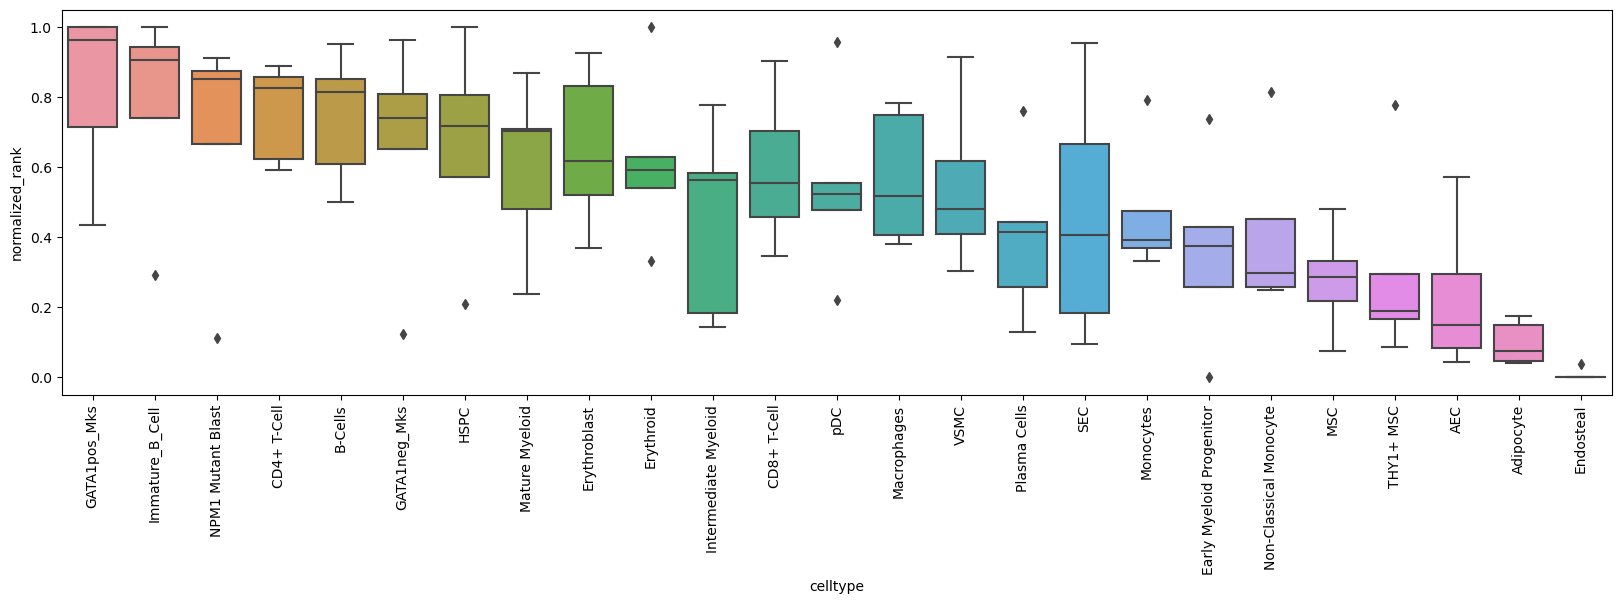

In [96]:
plt.figure(figsize=(20,5))
my_order = combined_df[combined_df['structure']=='bone'].groupby(by=['celltype'])['normalized_rank'].median().sort_values(ascending=False).index
sns.boxplot(x='celltype', y='normalized_rank', data=combined_df[combined_df['structure']=='bone'], order=my_order)
plt.xticks(rotation=90)
plt.show()

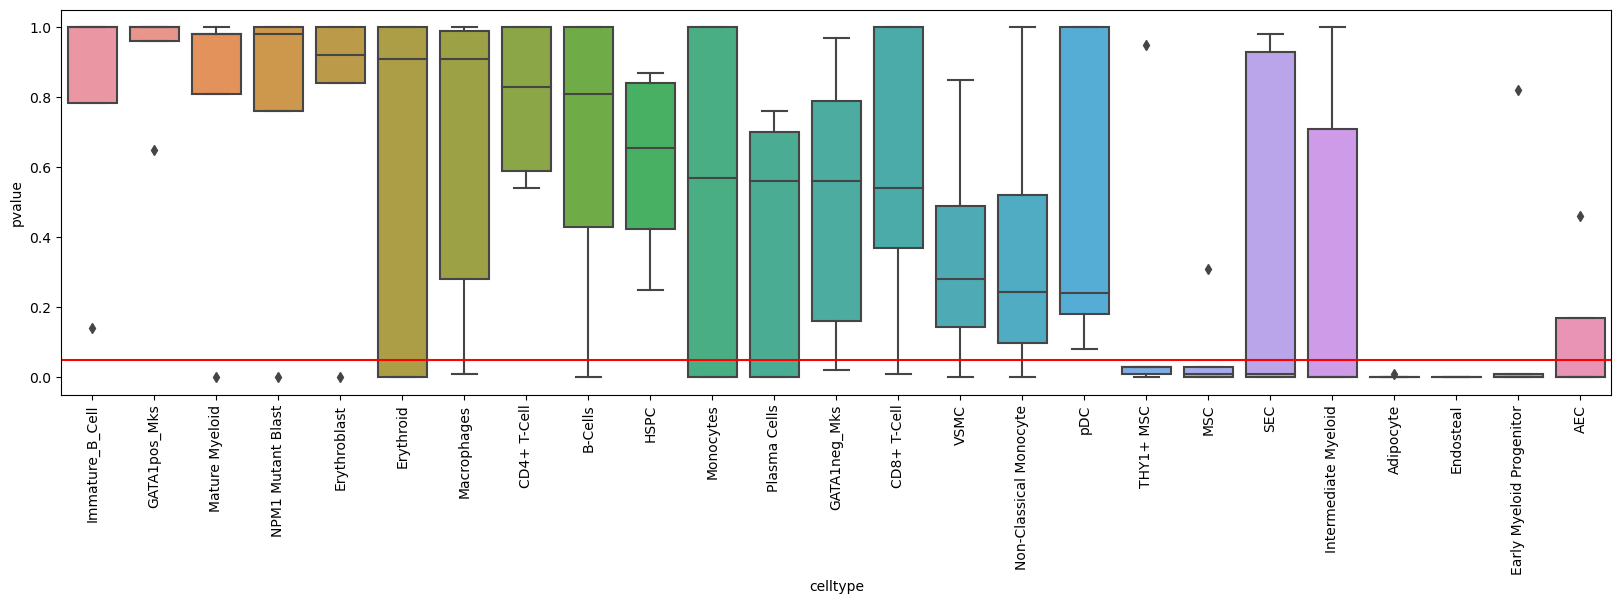

In [97]:
plt.figure(figsize=(20,5))
my_order = combined_df[combined_df['structure']=='bone'].groupby(by=['celltype'])['pvalue'].median().sort_values(ascending=False).index
sns.boxplot(x='celltype', y='pvalue', data=combined_df[combined_df['structure']=='bone'], order=my_order)
# add a line for pvalue=0.05
plt.axhline(y=0.05, color='r', linestyle='-')
plt.xticks(rotation=90)
plt.show()

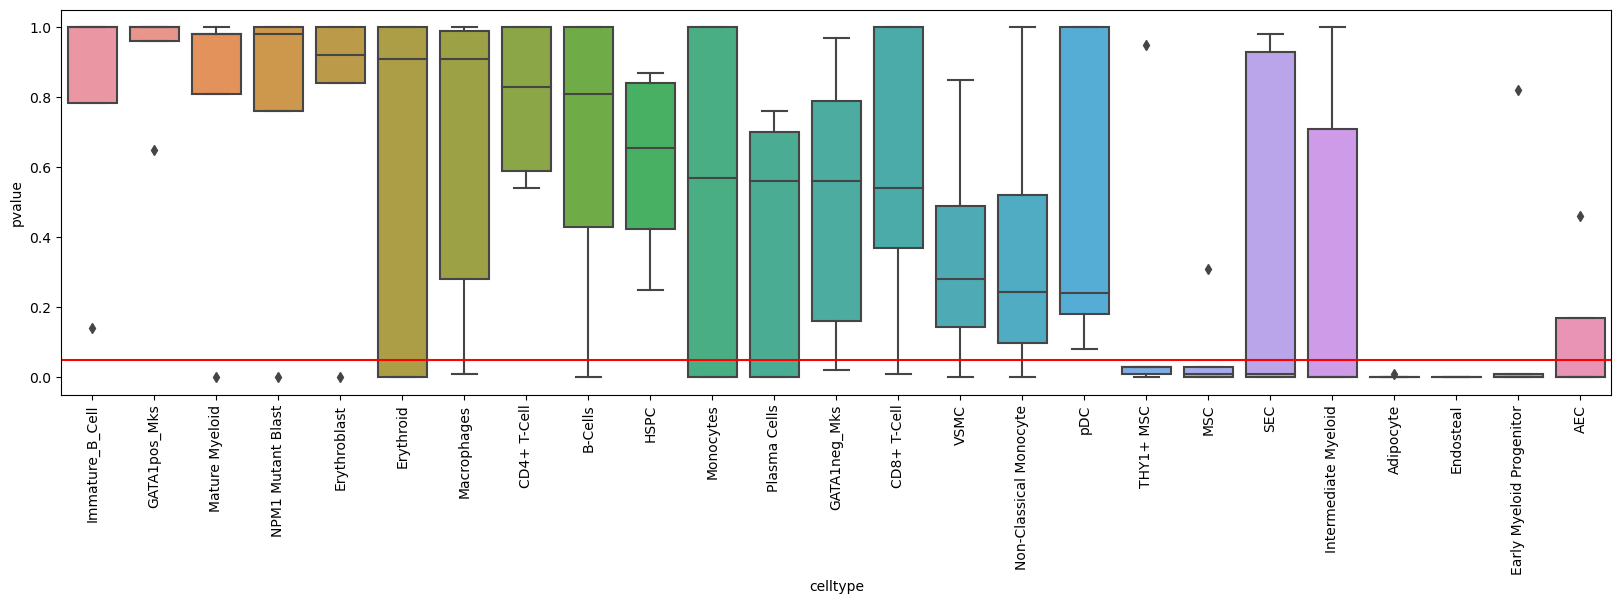

In [98]:
plt.figure(figsize=(20,5))
my_order = combined_df[combined_df['structure']=='bone'].groupby(by=['celltype'])['pvalue'].median().sort_values(ascending=False).index
sns.boxplot(x='celltype', y='pvalue', data=combined_df[combined_df['structure']=='bone'], order=my_order)
# add a line for pvalue=0.05
plt.axhline(y=0.05, color='r', linestyle='-')
plt.xticks(rotation=90)
plt.show()

# AML_NB

In [99]:
structures = ['bone','stroma', 'macrophage']
# 'stroma', 'macrophage', 
cls = 'neighbourhood'
combined_df = None
for structure in structures:
    sample_list = np.loadtxt('output_f/aml_nb_sample_list_' + structure + '.txt', dtype=str, delimiter="\n")
    celltype_list = np.loadtxt('output_f/aml_nb_celltype_list_' + structure + '.txt', dtype=str, delimiter="\n")
    coefficients_list_1 = np.loadtxt('output_f/aml_nb_coefficients_list_1_' + structure + '.txt', dtype=float)
    coefficients_list_2 = np.loadtxt('output_f/aml_nb_coefficients_list_2_' + structure + '.txt', dtype=float)
    pop_list = np.loadtxt('output_f/aml_nb_pop_list_' + structure + '.txt', dtype=float)
    distance_mean_list = np.loadtxt('output_f/aml_nb_distance_median_list_' + structure + '.txt', dtype=float)
    distance_sd_list = np.loadtxt('output_f/aml_nb_distance_sd_list_' + structure + '.txt', dtype=float)
    pvalue_list = np.loadtxt('output_f/aml_nb_pvalue_list_' + structure + '.txt', dtype=float)
    iqr_list = np.loadtxt('output_f/aml_nb_iqr_list_' + structure + '.txt', dtype=float)
    
    df = pd.DataFrame({'sample':sample_list, 'neighbourhood':celltype_list, 'coefficients_1':coefficients_list_1, 'coefficients_2':coefficients_list_2, 'populations':pop_list, 
                       'distance_median':distance_mean_list, 'distance_sd':distance_sd_list, 'pvalue':pvalue_list,
                       'distance_iqr':iqr_list})

    df['type'] = 'AML'
    df['distance_median'] = df['distance_median']*0.5
    df['distance_iqr'] = df['distance_iqr']*0.5
    df['distance_sd'] = df['distance_sd']*0.5
    df['structure'] = structure
    df['structure'] = df['structure'].replace('art', 'arteriole')
    df['-coefficients_2'] = -df['coefficients_2']
    # df = df[df['-coefficients_2'] > 1e-10]
    # df = df[df['populations']>10]
    df['rank'] = df.groupby(by=['sample','structure'])['-coefficients_2'].rank(ascending=False)
    # normalize the rank within each sample
    df['normalized_rank'] = df.groupby(by=['sample','structure'])['rank'].apply(lambda x: (x.rank()-1)/(len(x)-1))

    if combined_df is None:
        combined_df = df
    else:
        combined_df = pd.concat([combined_df, df])

# combined_df.to_csv('result/combined_v3_aml_' + cls + '.csv', index=False)
cnt = combined_df.groupby(by=['structure',cls]).agg({'sample':pd.Series.nunique})
# if sample size is less than 6, remove that item from combined_df
if len(cnt[cnt['sample']<3]>0):
    cnt = cnt.reset_index()
    cnt[cnt['sample']<3].to_csv('result/combined_v3_aml_' + cls + '_remove.csv', index=False)
    cnt = cnt[cnt['sample']>=3]
    cnt = cnt[['structure',cls]]
    combined_df = pd.merge(combined_df, cnt, on=['structure',cls], how='inner')

combined_df.to_csv('result/combined_v3_aml_' + cls + '.csv', index=False)
combined_df


,sample,neighbourhood,coefficients_1,coefficients_2,populations,distance_median,distance_sd,pvalue,distance_iqr,type,structure,-coefficients_2,rank,normalized_rank
0,183,2,-8.661485,-0.002657,1267.0,56.258424,20.528679,0.00,73.915322,AML,bone,0.002657,5.0,0.307692
1,183,4,-9.825583,-0.004062,330.0,52.512243,17.009109,0.00,53.420352,AML,bone,0.004062,2.0,0.076923
2,183,13,-10.637516,-0.001396,219.0,75.521160,28.664384,1.00,97.817583,AML,bone,0.001396,13.0,0.923077
3,183,12,-9.688595,-0.001621,541.0,62.995146,32.270401,0.19,132.103863,AML,bone,0.001621,7.0,0.461538
4,183,0,-8.883526,-0.003971,854.0,33.423326,16.052656,0.00,58.335745,AML,bone,0.003971,4.0,0.230769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,1443,8,-10.917437,-0.042550,209.0,10.866762,2.600426,1.00,9.464134,AML,macrophage,0.042550,14.0,0.928571
70,1443,12,-8.877714,-0.049800,1461.0,8.418725,2.377997,0.11,8.454328,AML,macrophage,0.049800,10.0,0.642857
71,1443,6,-10.264669,-0.053465,313.0,8.551685,2.013728,0.54,7.458300,AML,macrophage,0.053465,6.0,0.357143
72,1443,5,-10.072046,-0.052675,421.0,8.505215,2.271324,0.39,8.166039,AML,macrophage,0.052675,7.0,0.428571
